### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [72]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [73]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [74]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [75]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = load_y(y_train_path)
Y_test = load_y(y_test_path)
print(Y_train.shape, Y_test.shape)

(7352, 1) (2947, 1)


In [76]:
# Convert Y to one hot
Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [77]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = ... # select sample of given class c
    X_train_per_class[c] = X_train[mask]

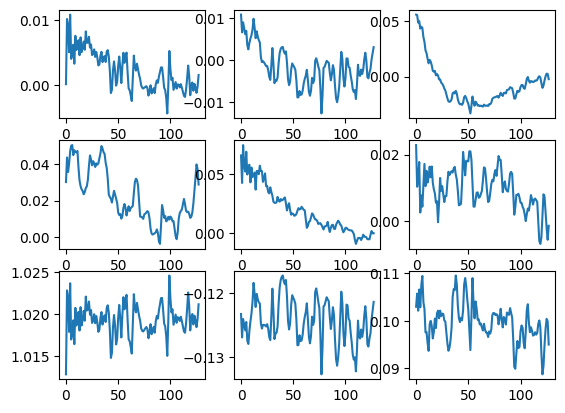

In [78]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [79]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Dataset

If suitable specify Dataset (e.g. in PyTorch).

In [80]:
...

Ellipsis

### Normalization

...

In [81]:
import tensorflow as tf
from tensorflow import keras
tf_version = tf.__version__

if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print(f'OK: TensorFlow {tf_version} >= 2.0.0' + '.\033[0m')

print("Available devices: ")
print(tf.config.list_physical_devices())

OK: TensorFlow 2.6.0 >= 2.0.0.
Available devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with a single layer of LSTM
* Model with several layers of LSTMs
* Model with several CNN layers
* MLP

Try with different number of units. Add regularisation if needed (e.g. when working with MLPs).

Report about your findings.

### Single Layer SimpleRNN

In [82]:
### START YOUR CODE
from tensorflow.keras.layers import SimpleRNN, Dense, Normalization, Input
from tensorflow.keras.models import Sequential


def get_model(normalization=False):
    n_hidden = 32
    input_shape = (X_train.shape[1], X_train.shape[2])

    sl_model = Sequential()

    if normalization:
        sl_model.add(Input(shape=input_shape))
        sl_model.add(Normalization(mean=means, variance=stdevs))

    sl_model.add(SimpleRNN(units=n_hidden, return_sequences=False, activation='tanh',
                        input_shape=input_shape))
    sl_model.add(Dense(units=N_CLASSES, activation='softmax'))

    # compile model
    sl_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    # ... print model information with summary() method
    sl_model.summary()

    return sl_model

### END YOUR CODE

In [83]:
### START YOUR CODE
batch_size = 128
n_epochs   = 20

print(X_train.shape, Y_train.shape)

sl_model = get_model()

sl_log = sl_model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))


(7352, 128, 9) (7352, 6)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 32)                1344      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 17s 280ms/step - loss: 1.6188 - accuracy: 0.3296 - val_loss: 1.4422 - val_accuracy: 0.3855
Epoch 2/20
58/58 [==============================] - 16s 277ms/step - loss: 1.3054 - accuracy: 0.4676 - val_loss: 1.4166 - val_accuracy: 0.3780
Epoch 3/20
58/58 [==============================] - 16s 272ms/step - loss: 1.1975 - accuracy: 0.5141 - val_loss: 1.2366 - val_accuracy: 0.4924
Epoch 4/20
58/58 [==============================] - 16s 270

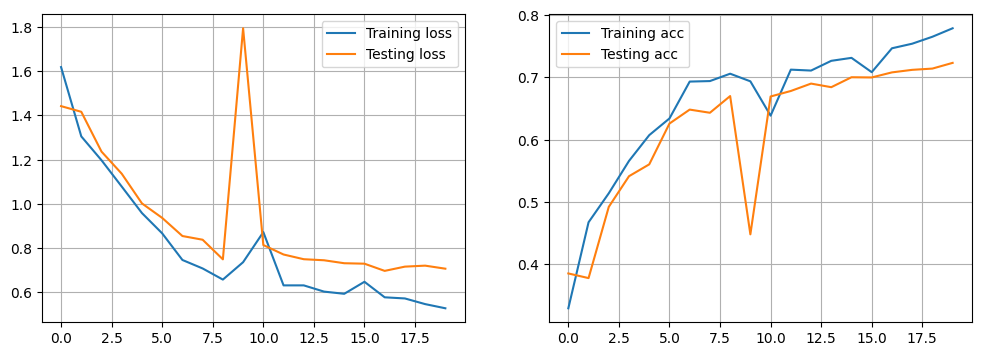

In [84]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(sl_log.history['loss'], label='Training loss')
ax1.plot(sl_log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(sl_log.history['accuracy'], label='Training acc')
ax2.plot(sl_log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [85]:
### START YOUR CODE
batch_size = 128
n_epochs   = 20

print(X_train.shape, Y_train.shape)

sl_model = get_model(normalization=True)

sl_log = sl_model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

(7352, 128, 9) (7352, 6)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 128, 9)            0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 32)                1344      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 17s 282ms/step - loss: 1.4995 - accuracy: 0.4180 - val_loss: 1.3389 - val_accuracy: 0.4533
Epoch 2/20
58/58 [==============================] - 17s 286ms/step - loss: 1.1340 - accuracy: 0.5781 - val_loss: 1.0231 - val_accuracy: 0.6091
Epoch 3/20
58/58 [==============================] - 16s 281ms/step - l

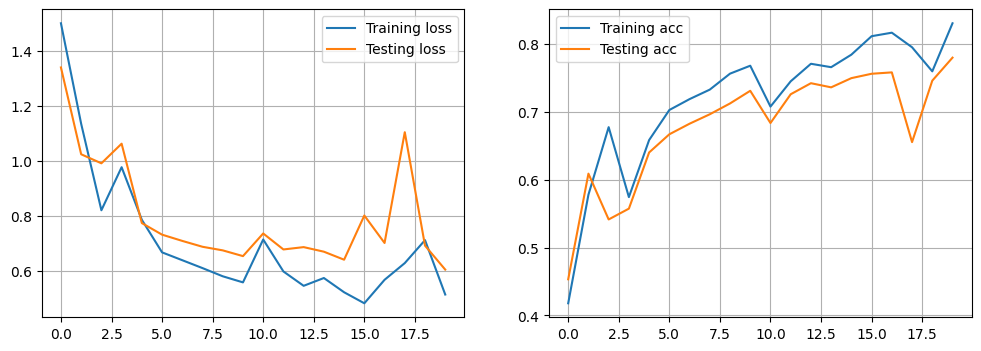

In [86]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(sl_log.history['loss'], label='Training loss')
ax1.plot(sl_log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(sl_log.history['accuracy'], label='Training acc')
ax2.plot(sl_log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [87]:
loss_test, metric_test = sl_model.evaluate(X_test, Y_test) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

93/93 [==============================] - 6s 62ms/step - loss: 0.6037 - accuracy: 0.7801
Test loss: 0.6036775708198547
Test accuracy: 0.7801153659820557


#### Findings

...

### LSTM

In [88]:
### START YOUR CODE
from tensorflow.keras.layers import LSTM, Dense, Normalization
from tensorflow.keras.models import Sequential


def get_lstm_model(normalization=False):
    n_hidden = 32
    input_shape = (X_train.shape[1], X_train.shape[2])

    lstm_model = Sequential()

    if normalization:
        lstm_model.add(Input(shape=input_shape))
        lstm_model.add(Normalization(mean=means, variance=stdevs))

    lstm_model.add(LSTM(units=n_hidden, input_shape=input_shape))
    lstm_model.add(Dense(units=N_CLASSES, activation='softmax', input_shape=(n_hidden,)))

    # compile model
    lstm_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    # ... print model information with summary() method
    lstm_model.summary()

    return lstm_model

### END YOUR CODE

In [89]:
### START YOUR CODE
batch_size = 128
n_epochs   = 20

lstm_model = get_lstm_model()

lstm_log = lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 3s 28ms/step - loss: 1.4666 - accuracy: 0.4244 - val_loss: 1.2660 - val_accuracy: 0.4496
Epoch 2/20
58/58 [==============================] - 1s 22ms/step - loss: 1.1369 - accuracy: 0.5356 - val_loss: 1.1604 - val_accuracy: 0.4968
Epoch 3/20
58/58 [==============================] - 1s 22ms/step - loss: 1.0386 - accuracy: 0.5514 - val_loss: 1.0909 - val_accuracy: 0.5365
Epoch 4/20
58/58 [==============================] - 1s 22ms/step - loss: 0.8870 - accuracy

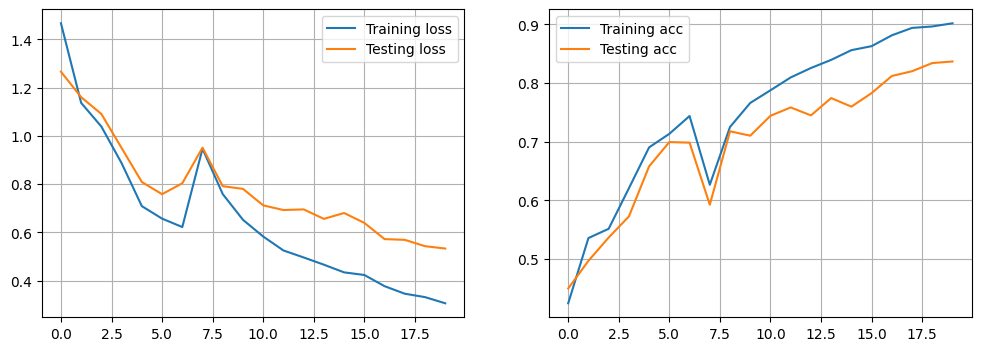

In [90]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(lstm_log.history['loss'], label='Training loss')
ax1.plot(lstm_log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(lstm_log.history['accuracy'], label='Training acc')
ax2.plot(lstm_log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [91]:
loss_test, metric_test = lstm_model.evaluate(X_test, Y_test) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

93/93 [==============================] - 1s 9ms/step - loss: 0.5334 - accuracy: 0.8368
Test loss: 0.5333964228630066
Test accuracy: 0.8367831707000732


In [92]:
### START YOUR CODE
batch_size = 128
n_epochs   = 20

lstm_model = get_lstm_model(normalization=True)

lstm_log = lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 128, 9)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 4s 29ms/step - loss: 1.4927 - accuracy: 0.4263 - val_loss: 1.2511 - val_accuracy: 0.4581
Epoch 2/20
58/58 [==============================] - 1s 22ms/step - loss: 0.9377 - accuracy: 0.6447 - val_loss: 0.8220 - val_accuracy: 0.6766
Epoch 3/20
58/58 [==============================] - 1s 22ms/step - loss: 0.6467 - accuracy: 0.7701 

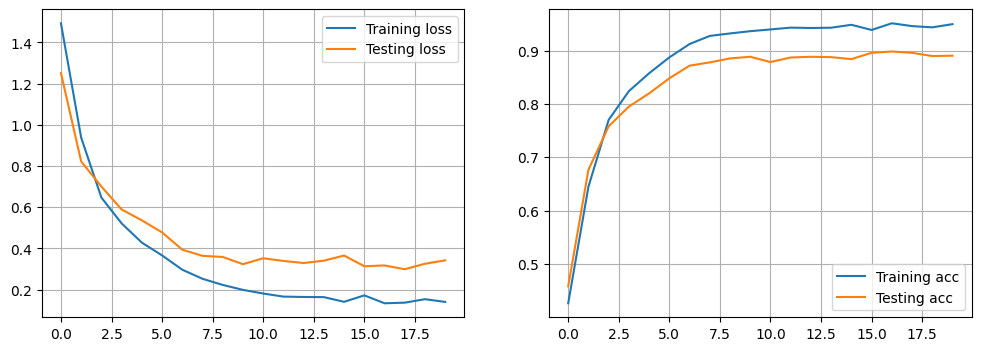

In [93]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(lstm_log.history['loss'], label='Training loss')
ax1.plot(lstm_log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(lstm_log.history['accuracy'], label='Training acc')
ax2.plot(lstm_log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [94]:
loss_test, metric_test = lstm_model.evaluate(X_test, Y_test) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

93/93 [==============================] - 1s 9ms/step - loss: 0.3420 - accuracy: 0.8904
Test loss: 0.3419850468635559
Test accuracy: 0.8903970122337341


#### Findings

The LSTM model performs better than the simple RNN model. Also, if input normalization is applied, the accuracy can be improved.

### Stacked LSTMs

In [95]:
### START YOUR CODE
from tensorflow.keras.layers import LSTM, Dense, Normalization
from tensorflow.keras.models import Sequential


def get_stacked_lstm_model(normalization=False):
    n_hidden = 32
    input_shape = (X_train.shape[1], X_train.shape[2])

    stacked_lstm_model = Sequential()

    if normalization:
        stacked_lstm_model.add(Input(shape=input_shape))
        stacked_lstm_model.add(Normalization(mean=means, variance=stdevs))

    stacked_lstm_model.add(LSTM(units=n_hidden, return_sequences=True, input_shape=input_shape))
    stacked_lstm_model.add(LSTM(units= n_hidden, return_sequences=True))
    stacked_lstm_model.add(LSTM(units=n_hidden))
    stacked_lstm_model.add(Dense(units=N_CLASSES, activation='softmax', input_shape=(n_hidden,)))

    # compile model
    stacked_lstm_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    # ... print model information with summary() method
    stacked_lstm_model.summary()

    return stacked_lstm_model

### END YOUR CODE

In [96]:
### START YOUR CODE
batch_size = 128
n_epochs   = 20

stacked_lstm_model = get_stacked_lstm_model()

stacked_lstm_log = stacked_lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_10 (LSTM)               (None, 128, 32)           8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 198       
Total params: 22,214
Trainable params: 22,214
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 8s 82ms/step - loss: 1.3828 - accuracy: 0.4457 - val_loss: 1.1361 - val_accuracy: 0.5538
Epoch 2/20
58/58 [==============================] - 3s 54ms/step - loss: 0.8875 - accuracy: 0.6503 - val_l

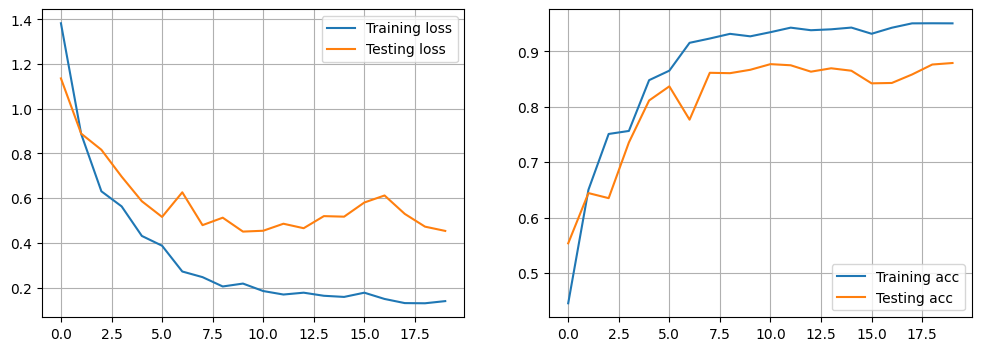

In [97]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(stacked_lstm_log.history['loss'], label='Training loss')
ax1.plot(stacked_lstm_log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(stacked_lstm_log.history['accuracy'], label='Training acc')
ax2.plot(stacked_lstm_log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [98]:
loss_test, metric_test = stacked_lstm_model.evaluate(X_test, Y_test) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

93/93 [==============================] - 2s 21ms/step - loss: 0.4534 - accuracy: 0.8789
Test loss: 0.4534493386745453
Test accuracy: 0.8788598775863647


In [99]:
### START YOUR CODE
batch_size = 128
n_epochs   = 20

stacked_lstm_model = get_stacked_lstm_model(normalization=True)

stacked_lstm_log = stacked_lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_7 (Normalizati (None, 128, 9)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
lstm_13 (LSTM)               (None, 128, 32)           8320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 198       
Total params: 22,214
Trainable params: 22,214
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 8s 70ms/step - loss: 1.2271 - accuracy: 0.5098 - val_loss: 0.81

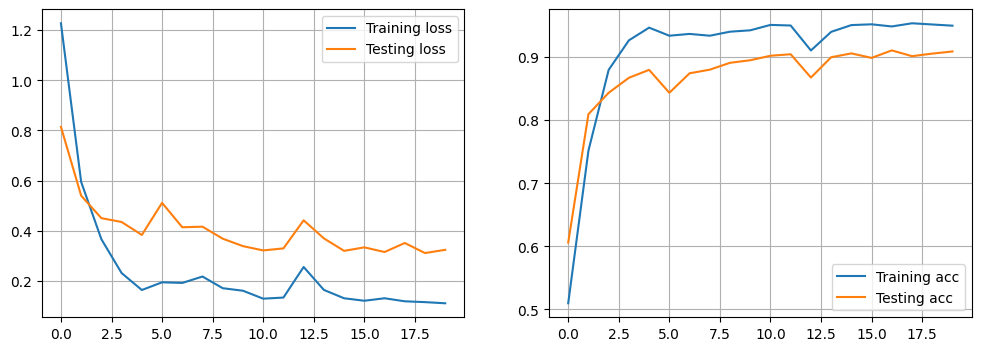

In [100]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(stacked_lstm_log.history['loss'], label='Training loss')
ax1.plot(stacked_lstm_log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(stacked_lstm_log.history['accuracy'], label='Training acc')
ax2.plot(stacked_lstm_log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [101]:
loss_test, metric_test = stacked_lstm_model.evaluate(X_test, Y_test) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

93/93 [==============================] - 2s 21ms/step - loss: 0.3246 - accuracy: 0.9091
Test loss: 0.32461193203926086
Test accuracy: 0.9090600609779358


#### Findings

There is a slight improvement with the stacked LSTM model. Also here, if input normalization is applied the accuracy is improved.

### CNN (Conv1d)

In [102]:
### START YOUR CODE

model = ...
...

### END YOUR CODE

Ellipsis

In [103]:
### START YOUR CODE
batch_size = ...
n_epochs   = ...


In [104]:
...

Ellipsis

#### Findings

...

### MLP

In [105]:
### START YOUR CODE

model = ...
...

### END YOUR CODE

Ellipsis

In [106]:
### START YOUR CODE
batch_size = ...
n_epochs   = ...


In [107]:
...

Ellipsis

#### Findings

...